# Readout distributions: measuring qubits

Measuring the state of a qubit is the fundamental operation we need to perform to know anything about our experiments on a quantum computer.

In this notebook, you will ...
* ... understand how the measurement of qubits works in a superconducting quantum computer.

By the end of this notebook, you will not only have a basic understanding of how to execute pulse schedules, but you will also have a feeling for the outcome to expect in your experiments.

In order to get started, make sure you have the appropriate packages installed:

In [ ]:
%%capture 
!pip install iqm-client
!pip install iqm-pulla 
!pip install matplotlib
!pip install pylatexenc

## 1. Preparation

### 1.1 Connecting to the QPU station control
In the following, we will use the PulLa (Pulse Level Access) package. You can find the documentation [here](https://docs.meetiqm.com/iqm-pulla/).

As a first step, we need to create a **PulLa object**. In general, this is a **compiler**, in a particular state, linked to a particular quantum computer. It contains calibration data and the set of available operations. 

Make sure you have the correct url and token below.

In [ ]:
from iqm.pulla.pulla import Pulla
import os
from iqm.iqm_client.authentication import TokenManager

# On-premise
#os.environ["IQM_TOKENS_FILE"]="your-token-here"
#p = Pulla("your-url-here", get_token_callback=TokenManager().get_bearer_token) 

#Resonance 
api_token = input()
p = Pulla("https://cocos.resonance.meetiqm.com/sirius", get_token_callback=lambda: api_token) 

compiler = p.get_standard_compiler()

## 2. Measurement operation

Qubit readout in superconducting systems is done via **superconducting resonators** (e.g. LC oscillators) that are coupled to the transmon qubits in the QPU. The coupling between the qubit and the resonator can be described with the [Jaynes-Cummings model](https://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model), which allows for two different regimes of the system, the **resonant** and the **dispersive** one. In the latter, looking at the spectrum of the resonator, one can infer the state of the qubit thanks to the **shift** in the resonator's frequency caused by the coupling.

The raw measurement signal is typically represented as a **complex number** as function of time. The measurement instrument integrates the signal over time to yield a complex number, one per measurement operation.

What we are used to see as a result of a measurement looks different though, right? An extra step is required: the complex number is rotated so that the difference between the states is maximal along the real axis. The real value of the signal is then compared with a **calibrated threshold value**, from which we get the well known 0/1 labels :)

In the following, **we will not perform the thresholding** to investigate and get familiar with the raw results of a measurement operation! 

### 2.1 Measuring a qubit in different states

Knowing now that the readout signal depends on the state of the qubit, our strategy will be to prepare the qubits in different states and compare observations! 
We will inspect the results of 3 circuits:
1. Prepare a qubit in the $|0\rangle$ state and measure.
2. Prepare a qubit in the $|1\rangle$ state and measure.
3. Prepare a qubit in the superposition of $|0\rangle$ and $|1\rangle$ and measure.

Below we use the IQM Pulse syntax to define the circuits (you can find the documentation [here](https://docs.meetiqm.com/iqm-pulse/)).

The PRX gate is defined as $R_{\phi}(\theta) = e^{-i(X cos(\phi)+Y sin(\phi))\frac{\theta}{2}}$. We can prepare the qubit in the three different states above changing the rotation angle $\theta$ and setting the phase angle $\phi$ to zero. 

In [2]:
from iqm.cpc.interface.compiler import Circuit, CircuitOperation as Op
import numpy as np

qubit = "QB1"
circuits = []
for name, angle in zip(["state0", "state1", "superposition"], [0.0, np.pi, np.pi/2]):
    circuit = Circuit(name, [
        Op("prx", (qubit,), args={"angle": angle, "phase": 0.0}),
        Op("measure", (qubit,), args={"key": "M"})
    ])
    circuits.append(circuit)


To see the unthresholded signals, we need to tweak the **calibration settings** of the `measure` operation.

The `measure` operation can be implemented in more than one way. To see the available settings of all implementations, you can use `print_implementations_trees` (the first one in the list is the default).

In [3]:
compiler.print_implementations_trees(compiler.builder.op_table["measure"])


 "Operation: measure, implementation: constant"
 ╠─ duration: Readout pulse duration = None (automatic/unspecified)
 ╠─ frequency: Readout pulse frequency = None (automatic/unspecified)
 ╠─ phase: Readout pulse phase = None (automatic/unspecified)
 ╠─ amplitude_i: Readout channel I amplitude = None (automatic/unspecified)
 ╠─ amplitude_q: Readout channel Q amplitude = 0.0 
 ╠─ integration_length: Integration length = None (automatic/unspecified)
 ╠─ integration_weights_I: Integration weights for channel I = [] 
 ╠─ integration_weights_Q: Integration weights for channel Q = [] 
 ╠─ integration_threshold: Integration threshold = None (automatic/unspecified)
 ╠─ acquisition_type: Acquisition type = threshold 
 ╚─ acquisition_delay: Acquisition delay = None (automatic/unspecified)

 "Operation: measure, implementation: constant_qnd"
 ╠─ duration: Readout pulse duration = None (automatic/unspecified)
 ╠─ frequency: Readout pulse frequency = None (automatic/unspecified)
 ╠─ phase: Readout p

We need to change the `acquisition_type` of the `constant` implementation from `threshold` to `complex`.

In [4]:
compiler.amend_calibration_for_gate_implementation("measure", "constant", (qubit, ), {"acquisition_type": "complex"})

Now we can execute the circuits with the modified settings:

In [5]:
playlist, context = compiler.compile(circuits)
settings, context = compiler.build_settings(context, shots=1000)
job = p.execute(playlist, context, settings, verbose=False)

[03-11 10:28:28;I] Submitted sweep with ID: e185fc54-4715-4460-9640-e53867e53f3f
[03-11 10:28:28;I] Created task in queue with ID: 68149aa9-c59a-4676-b769-d3df857e6a65
[03-11 10:28:28;I] Waiting for the sweep to finish...
[03-11 10:28:32;I] Sweep status: SweepStatus.SUCCESS


## 3. Analyze the results

Now that the 'playlist' of instructions above has successfully run, we can extract the results and compare them visualizing their real and imaginary part. 

We start with the first two state preparations in the $|0\rangle$ and $|1\rangle$ states:

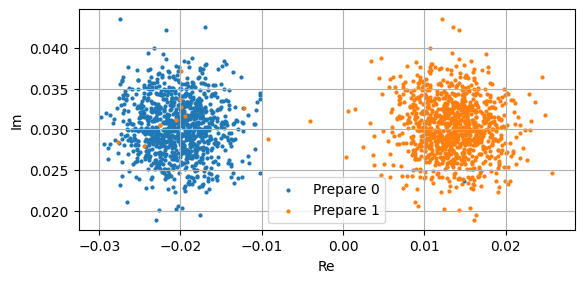

In [6]:
import matplotlib.pyplot as plt

state_0_results = np.array(job.result[0]["M"]).squeeze()
state_1_results = np.array(job.result[1]["M"]).squeeze() 
plt.figure()    
plt.scatter(np.real(state_0_results), np.imag(state_0_results), label="Prepare 0", s=4)
plt.scatter(np.real(state_1_results), np.imag(state_1_results), label="Prepare 1", s=4)
plt.xlabel('Re')
plt.ylabel('Im')
plt.gca().set_aspect('equal')
plt.grid()
plt.legend();


Time to stop and think! Let's make some important observations about these results:

- When preparing state $|0\rangle$ $\left(|1\rangle\right)$, most of the shots are **clustered** on the left (right). The signal has been calibrated so that the difference is maximized along the real axis.
- However, some shots are in the wrong cluster. 

This is due to various state preparation, gate, and measurement errors.

As we have said already above, to convert a shot to a 0 or 1 label, the system would compare the real part of the measurement shot to a threshold `t` located somewhere in the middle of the two clusters.
If `Re(shot) < t`, the result is labeled as 0, and 1 if `Re(shot) > t`. 

Curious to know what the the calibrated `t` was? Run the code below!

In [ ]:
t_cal = compiler.get_calibration()[f"gates.measure.constant.{qubit}.integration_threshold"]
print(t_cal)

-0.0051364867100234645

What about the superposition state?

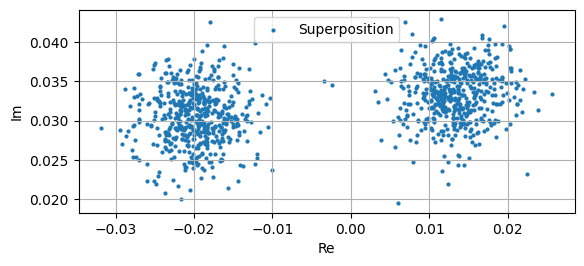

In [8]:
superposition_results = np.array(job.result[2]["M"]).squeeze()

plt.figure()    
plt.scatter(np.real(superposition_results), np.imag(superposition_results), label="Superposition", s=4)
plt.xlabel('Re')
plt.ylabel('Im')
plt.gca().set_aspect('equal')
plt.grid()
plt.legend();

We observe that the clusters are in the same locations as for 0 and 1. Moreover, there is no "continuum" of shots between the two clusters, apart from few ones due to noise.

## 4. Let's play with calibration!
Now that we have seen what the typical behaviour should look like for your readout experiments, we can have some fun and tweek a couple of calibration parameters to see how the reults change. 

This is interesting to understand the effects of bad calibration in fundamental operations like the measurement one.  

#### 4.1 Change the threshold
Change `"acquisition_type"` back to `"threshold"` and choose a new `"gates.measure.constant.QB1.integration_threshold"`, then repeat the experiment. 

What happens for the superposition state? 

In [ ]:
compiler = p.get_standard_compiler() # Get a new compiler to reset the settings
compiler.amend_calibration_for_gate_implementation(
    "measure", "constant", (qubit,), {"integration_threshold": t_cal*10, "acquisition_type": "threshold"} 
)

In [10]:
playlist, context = compiler.compile(circuits)
settings, context = compiler.build_settings(context, shots=1000)
job = p.execute(playlist, context, settings, verbose=False)

[03-11 10:32:53;I] Submitted sweep with ID: dea45ac7-882f-47c3-a669-23e2da7ddcb5
[03-11 10:32:53;I] Created task in queue with ID: 533d5862-bd99-4d8d-a9e9-fcc1eefdf1b6
[03-11 10:32:53;I] Waiting for the sweep to finish...
[03-11 10:32:57;I] Sweep status: SweepStatus.SUCCESS


In [11]:
from collections import Counter
counts = Counter(np.array(job.result[2]["M"]).squeeze())
print("0:", counts[0])
print("1:", counts[1])

0: 1000
1: 0


We see that the distribution of counts is not 50-50 anymore because we misinterpret the raw signal and assign wrong 0/1 labels!

#### 4.2 Change the drive amplitude

Change the parameter `"gates.measure.constant.QB1.amplitude_i"` in the interval $[0.0, 0.35]$ and repeat the experiment. 

What happens for the $|0\rangle$ and $|1\rangle$ states? 

[03-11 10:34:40;I] Submitted sweep with ID: ba82cd74-022a-4866-a533-6223ecff5c5e
[03-11 10:34:40;I] Created task in queue with ID: 6d58141c-750b-4314-afaa-aef89795bb8d
[03-11 10:34:40;I] Waiting for the sweep to finish...
[03-11 10:34:44;I] Sweep status: SweepStatus.SUCCESS


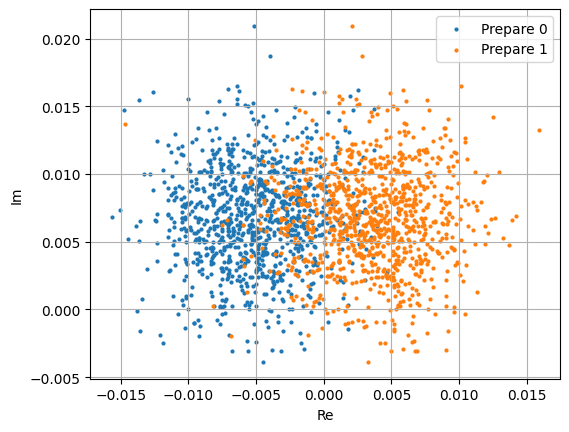

In [12]:
compiler = p.get_standard_compiler() # Get a new compiler to reset the settings
compiler.amend_calibration_for_gate_implementation("measure", "constant", (qubit,), 
                                                   {"amplitude_i": 0.05, "acquisition_type": "complex"}) 

playlist, context = compiler.compile(circuits)
settings, context = compiler.build_settings(context, shots=1000)
job = p.execute(playlist, context, settings, verbose=False)

state_0_results = np.array(job.result[0]["M"]).squeeze()
state_1_results = np.array(job.result[1]["M"]).squeeze() 
plt.figure()    
plt.scatter(np.real(state_0_results), np.imag(state_0_results), label="Prepare 0", s=4)
plt.scatter(np.real(state_1_results), np.imag(state_1_results), label="Prepare 1", s=4)
plt.xlabel('Re')
plt.ylabel('Im')
plt.gca().set_aspect('equal')
plt.grid()
plt.legend();

We can see that for small values of the amplitude, the clusters overlap more and they are not well separated. 

For high values of the amplitude instead, the clusters will be further apart, but they could be distorted. In fact, too high amplitudes could blast the readout resonator and the qubit into higher states, making other clusters appear in the plot above.

In [ ]:
# Copyright 2025 IQM Quantum Computers (Joni Ikonen, Nadia Milazzo)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.